In [17]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np

from contact_graspnet.dataloading import OrigExampleData, YCBSimulationData
from contact_graspnet.preprocessing import Img2CamCoords, Depth2ImgPoints, ZClipper, UniversalPreprocessor, SegmentationBinarizer, Resizer
from contact_graspnet.postprocessing import Postprocessor, TopScoreFilter, Cam2WorldGraspConverter, Cam2WorldCoordConverter
from contact_graspnet.models import ContactGraspnet
from contact_graspnet.utils.visualization import mlab_pose_vis
from contact_graspnet.utils.misc import get_root_dir, setup_tensorflow

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
setup_tensorflow()

In [3]:
# dataset = OrigExampleData(
#     get_root_dir() / "data" / "raw" / "orig_test_data",
#     transform=UniversalPreprocessor(
#         depth2points_converter=Depth2ImgPoints(),
#         img2cam_converter=Img2CamCoords(),
#         z_clipper=ZClipper([0.2, 1.8]),
#         segmentation_binarizer=SegmentationBinarizer(2.0),
#     ),
# )

dataset = YCBSimulationData(
    Path.home() / "Documents" / "ycb_sim_data_1",
    transform=UniversalPreprocessor(
        depth2points_converter=Depth2ImgPoints(),
        img2cam_converter=Img2CamCoords(),
        z_clipper=ZClipper([0.2, 1.8]),
        # segmentation_binarizer=SegmentationBinarizer(),
    ),
)

008_gelatin_box


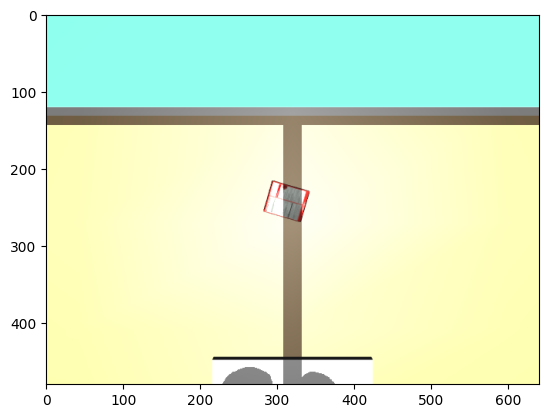

In [4]:
full_pc, segmented_pc = dataset[7]

sample = dataset.transform.intermediate_results["initial_sample"]
print(sample.name)
plt.imshow(sample.rgb)

In [5]:
model = ContactGraspnet(
    get_root_dir()
    / "checkpoints"
    / "scene_test_2048_bs3_hor_sigma_001"
    / "config.yaml",
    get_root_dir() / "checkpoints" / "scene_test_2048_bs3_hor_sigma_001",
)

--- Get model


/home/moritz/Documents/ContactGraspnetBenchmark/contact_graspnet/orig/pointnet2/utils/tf_util.py:571: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  momentum=bn_decay, axis=axis, name=scope,


('loading ', '/home/moritz/Documents/ContactGraspnetBenchmark/contact_graspnet/checkpoints/scene_test_2048_bs3_hor_sigma_001/model.ckpt-54054')


In [6]:
postprocessor = Postprocessor(top_score_filter=None)

In [7]:
network_output = (pred_grasps_cam, scores, contact_pts, widths) = model(full_pc, segmented_pc)

grasps_sim_cam = postprocessor(network_output)

Extracted Region Cube Size:  0.3
Generated 6 grasps for object -1


In [8]:
mlab_pose_vis(
    full_pc,
    postprocessor.intermediate_results["all_grasps_paper"],
    dataset.transform.intermediate_results["full_pc_colors"],
)

# mlab_pose_vis(
#     segmented_pc,
#     postprocessor.intermediate_results["all_grasps_paper"],
#     preprocessor.intermediate_results["segmented_pc_colors"],
# )

In [9]:
best_grasp_sim_cam = max(grasps_sim_cam, key=lambda g: g.score)

In [12]:
cam2world = Cam2WorldGraspConverter()

best_grasp_world = cam2world(best_grasp_sim_cam, sample.cam_pos, sample.cam_rot)

NotImplementedError: Axes3D currently only supports the aspect argument 'auto'. You passed in 'equal'.

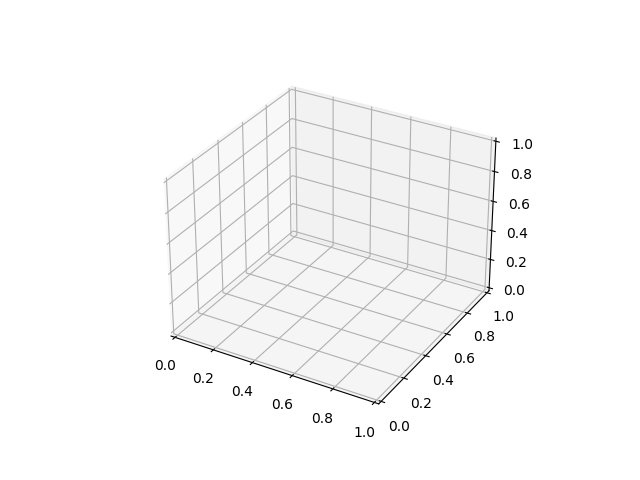

In [20]:
cam2world_coord = Cam2WorldCoordConverter()

pc_world = np.array([cam2world_coord(p, sample.cam_pos, sample.cam_rot) for p in full_pc[::100]])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_aspect('equal')
  
ax.scatter(pc_world[:, 0], pc_world[:, 1], pc_world[:, 2])# , c=dataset.transform.intermediate_results["full_pc_colors"])
ax.scatter(best_grasp_world.position[0], best_grasp_world.position[1], best_grasp_world.position[2], c="r", s=100)

plt.show()